#Homework 6: Predicticting the price of houses using Regression Trees

The goal of this homework is to create tree-based regression models for prediction of apartment prices (column `'price'`).

We use the New York City Airbnb Open Data dataset from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)


##Let's load the data:

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Setting up google colab to upload, unzip and read the data from Kaggle.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [22]:
#Update Kaggle path to pwd
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [23]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AB_NYC_2019.csv         
replace New_York_City_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: New_York_City_.png      


In [25]:
df_all = pd.read_csv('AB_NYC_2019.csv')

####In this project we will use the following columns

In [26]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]


In [27]:
df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   room_type                       48895 non-null  object 
 4   price                           48895 non-null  int64  
 5   minimum_nights                  48895 non-null  int64  
 6   number_of_reviews               48895 non-null  int64  
 7   reviews_per_month               38843 non-null  float64
 8   calculated_host_listings_count  48895 non-null  int64  
 9   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 3.7+ MB


####Check for missing values and fill it with 0s

In [29]:
df.isna().sum()

neighbourhood_group                   0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [30]:
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [31]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


####Apply the log tranform to `price`
#### Do train/validation/test split with 60%/20%/20% distribution. 
#### Use the `train_test_split` function and set the `random_state` parameter to 1

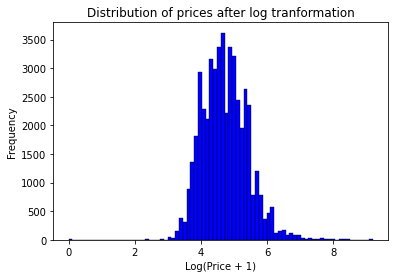

In [33]:
log_price = np.log1p(df.price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=80, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

In [34]:
df['log_price'] = np.log1p(df.price)

###Setting Up Validation Framework

In [37]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [38]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [39]:
y_train = df_train.log_price
y_val = df_val.log_price
y_test = df_test.log_price

In [40]:
del df_train['log_price']
del df_val['log_price']
del df_test['log_price']

del df_train['price']
del df_val['price']
del df_test['price']

###One-hot encoding

Now, use `DictVectorizer` to turn train and validation into matrices:

Separate categorical variables from numerical

In [290]:
#numerical = df_train_full.select_dtypes(exclude=['object']).columns.tolist()
#categorical = df_train_full.select_dtypes(include=['object']).columns.tolist()

In [41]:
from sklearn.feature_extraction import DictVectorizer

In [42]:
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')

In [43]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

####We'll use `DecisionTreeRegressor`

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.metrics import mean_squared_error as MSE
from sklearn import tree
from sklearn.tree import export_text, export_graphviz
import graphviz

Fit model with max_depth = 1 

In [45]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [50]:
y_pred_val = dtr.predict(X_val)

In [47]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [48]:
rmse(y_val, y_pred_val)

0.5488190627763665

In [51]:
mse = MSE(y_val, y_pred_val)
mse


0.301202363666734

In [52]:
rmse = np.sqrt(mse)
rmse

0.5488190627763707

####Visualizing the tree

In [53]:
from sklearn.tree import export_text

print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



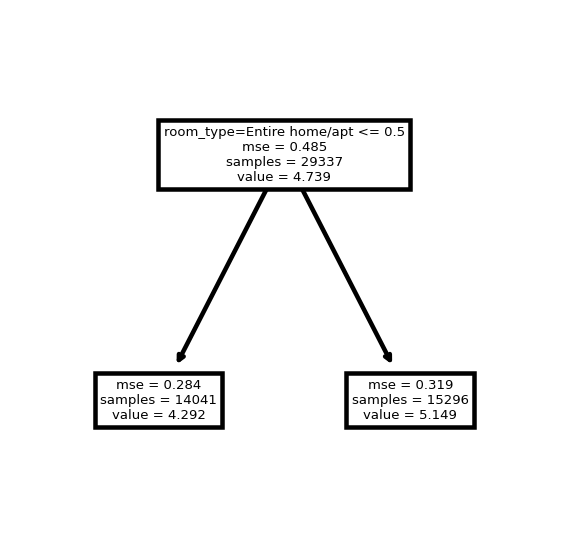

In [54]:
# Let's set dpi = 325 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=325)

tree.plot_tree(dtr, feature_names = dv.get_feature_names())
plt.show()

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

**Answer One: ``room_type``**

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [56]:
from sklearn import metrics

from sklearn.metrics import mean_squared_error
import math

In [57]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_val)

print('Root Mean Squared Error = {0}'.format(np.sqrt(MSE(y_val, y_pred))))

Root Mean Squared Error = 0.460888788095762


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

####**Answer 2: RMSE on validation is 0.459**

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [58]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred_val = rf.predict(X_val)
    rmse = np.sqrt(MSE(y_val, y_pred_val))
    
    scores.append((n, rmse))

In [59]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)   

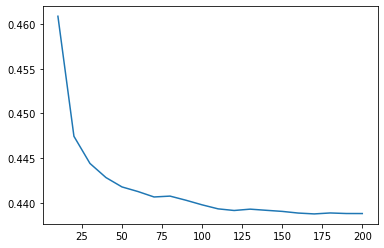

In [60]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

####**Answer 3. The RMSE stops improving after n_estimators = 120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [61]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred_val = rf.predict(X_val)
        rmse = np.sqrt(MSE(y_val, y_pred_val))

        scores.append((d, n, rmse))

In [62]:
columns = ['max_depth','n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)

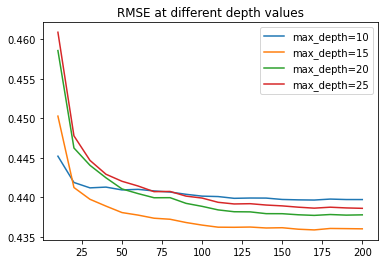

In [63]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.title('RMSE at different depth values')
plt.legend()
plt.show()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

####**Answer 4. The best max_depth is 15**

Let's change the randon_state to 2

In [64]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=2)
        rf.fit(X_train, y_train)

        y_pred_val = rf.predict(X_val)
        rmse = np.sqrt(MSE(y_val, y_pred_val))

        scores.append((d, n, rmse))

In [65]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators','rmse'])

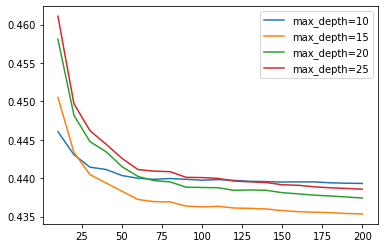

In [67]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

####**No change in the answer**

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [68]:
rf = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_val = rf.predict(X_val)

print('Root Mean Squared Error = {0}'.format(np.sqrt(MSE(y_val, y_pred_val))))

print('Feature importances: {0}'.format(rf.feature_importances_))

Root Mean Squared Error = 0.44520997451725497
Feature importances: [5.92287552e-02 2.14539978e-02 1.06857456e-01 1.11320969e-01
 4.20365244e-02 9.01475777e-05 1.81309527e-04 4.75866608e-02
 3.70520540e-04 4.92966349e-05 2.09295605e-02 2.47090634e-02
 5.53151574e-01 5.65041347e-03 6.38375138e-03]


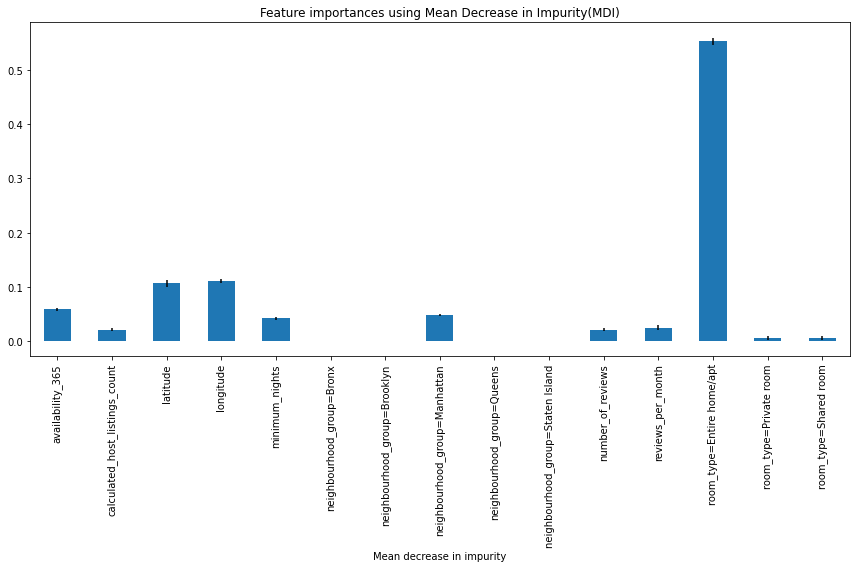

In [69]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=dv.feature_names_)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots(figsize = (12,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity(MDI)")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

####**Most important feature is room_type=Entire home/apt**

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [70]:
import xgboost as xgb

In [71]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [72]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [73]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model3 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                   verbose_eval=5,
                   evals=watchlist)


In [74]:
eta_3 = output.stdout

In [75]:
print(eta_3[:100])

[0]	train-rmse:3.02752	val-rmse:3.02415
[5]	train-rmse:0.674904	val-rmse:0.677523
[10]	train-rmse:0.


In [76]:
y_pred_val3 = model3.predict(dval)

In [77]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [78]:
df_score3 = parse_xgb_output(output)

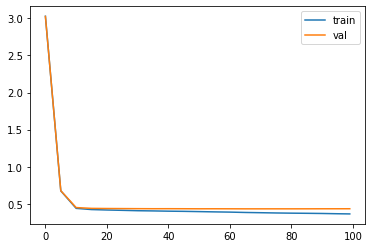

In [79]:
plt.plot(df_score3.num_iter, df_score3.train_auc, label='train')
plt.plot(df_score3.num_iter, df_score3.val_auc, label='val')
plt.legend()
plt.show()

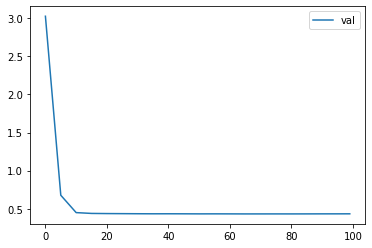

In [80]:
plt.plot(df_score3.num_iter, df_score3.val_auc, label='val')
plt.legend()
plt.show()

Now change `eta` first to `0.1` and then to `0.01`

In [81]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model1 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                   verbose_eval=5,
                   evals=watchlist)

In [82]:
eta_1 = output.stdout

In [83]:
print(eta_1[:100])

[0]	train-rmse:3.87217	val-rmse:3.86889
[5]	train-rmse:2.31905	val-rmse:2.31689
[10]	train-rmse:1.41


In [84]:
y_pred_val1 = model1.predict(dval)

In [85]:
df_score1 = parse_xgb_output(output)

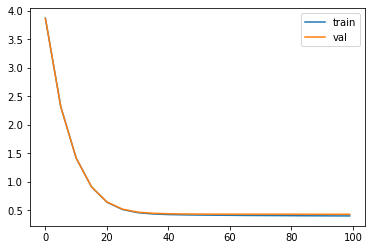

In [86]:
plt.plot(df_score1.num_iter, df_score1.train_auc, label='train')
plt.plot(df_score1.num_iter, df_score1.val_auc, label='val')
plt.legend()
plt.show()

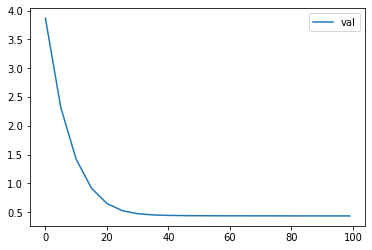

In [87]:
plt.plot(df_score1.num_iter, df_score1.val_auc, label='val')
plt.legend()
plt.show()

In [88]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model01 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                    verbose_eval=5,
                    evals=watchlist)

In [89]:
eta_01 = output.stdout

In [90]:
print(eta_01[:100])

[0]	train-rmse:4.25336	val-rmse:4.2501
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.852


In [91]:
y_pred_val01 = model01.predict(dval)

In [92]:
df_score01 = parse_xgb_output(output)

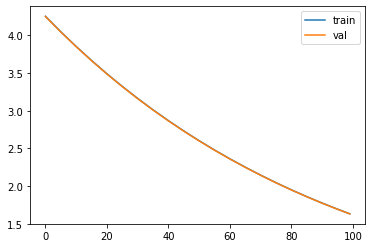

In [93]:
plt.plot(df_score01.num_iter, df_score01.train_auc, label='train')
plt.plot(df_score01.num_iter, df_score01.val_auc, label='val')
plt.legend()
plt.show()

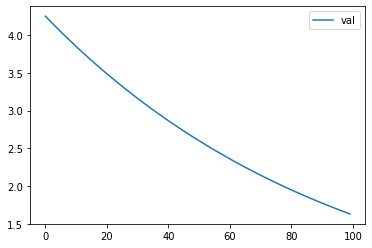

In [94]:
plt.plot(df_score01.num_iter, df_score01.val_auc, label='val')
plt.legend()
plt.show()

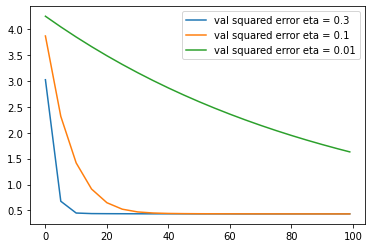

In [95]:
plt.plot(df_score01.num_iter, df_score3.val_auc, label='val squared error eta = 0.3')
plt.plot(df_score01.num_iter, df_score1.val_auc, label='val squared error eta = 0.1')
plt.plot(df_score01.num_iter, df_score01.val_auc, label='val squared error eta = 0.01')
plt.legend()
plt.show()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

####**The best eta in our case is 0.3 as this gives the lowest squared error.**